# Predict House Price
### Using xgBoost with Search Grid
Original full House Price prediction can be found here: 
https://github.com/ScottySchmidt/Kaggle/blob/main/PredictHousePrices.ipynb

##### Special Notes:
* Tunning learning_rate improved 8% better score
* Removing outliers improved 4% better score
* Removing similiar features makes couple percent better score
* Adding saleCondition improved .5% better score
* Tuning ETA have little to no effect
* Early_stopping_rounds=5 makes little to no effect (which makes sense because I used a CV)
* Encoding condition1 improved score by less than 1%

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
warnings.warn('my warning')

data='/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
df=pd.read_csv(data)
print(df.shape)
df.head()

(1460, 81)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: my warning
  


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Missing Values

In [2]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(data)
    print(findNA.head(10))
findNA() 

Missing data by column as a percent:
PoolQC          21.686567
MiscFeature     20.985075
Alley           20.432836
Fence           17.597015
FireplaceQu     10.298507
LotFrontage      3.865672
GarageYrBlt      1.208955
GarageCond       1.208955
GarageType       1.208955
GarageFinish     1.208955
dtype: float64


In [3]:
df=df.fillna(df.mean())
df=df.drop(columns=['MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])
print(df.shape)

(1460, 77)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPo

# Encode Data

In [5]:
df['totalSQ']=df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF']
df=df.drop(columns=['1stFlrSF', '2ndFlrSF','TotalBsmtSF'])
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,totalSQ
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,2,2008,WD,Normal,208500,2566
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,NaN,0,5,2007,WD,Normal,181500,2524
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2008,WD,Normal,223500,2706
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,NaN,0,2,2006,WD,Abnorml,140000,2473
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,NaN,0,12,2008,WD,Normal,250000,3343


In [6]:
#print(df['Condition2'].value_counts())
#print(df['Condition1'].value_counts())
df['CentralAir'] = df['CentralAir'].replace({'Y':0, 'N':1})

#BELOW GOT REMOVED has 0% feature importance:
#df['Condition2']=df['Condition2'].apply(lambda x: 1 if x=='Norm' else 0)
#df['SaleCondition']=df['SaleCondition'].apply(lambda x:1 if x == 'Normal' else 0)
#df['Street']=df['Street'].fillna(0).apply(lambda x:0 if x =='Grvl' else 1)
#df['Condition1']=df['Condition1'].apply(lambda x: 1 if x=='Norm' else 0)
#print(df['SaleCondition'].value_counts())
#df['SaleCondition']=df['SaleCondition'].apply(lambda x:2 if x=='Normal' else 0)

In [7]:
df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,totalSQ
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,61,0,0,0,0,0,2,2008,208500,2566
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,0,5,2007,181500,2524
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,42,0,0,0,0,0,9,2008,223500,2706
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,35,272,0,0,0,0,2,2006,140000,2473
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,84,0,0,0,0,0,12,2008,250000,3343


# Outliers

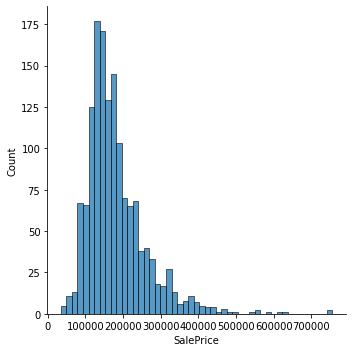

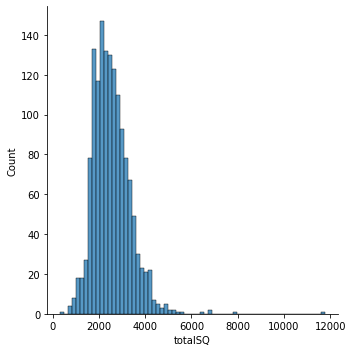

In [8]:
import seaborn as sns
sns.displot(df, x='SalePrice')
sns.displot(df, x='totalSQ')

In [9]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers
priceOutlier=list(detect_outlier(df['SalePrice']))
print(priceOutlier)
sqOutlier=list(detect_outlier(df['totalSQ']))
print(sqOutlier)

[438780, 501837, 475000, 437154, 426000, 555000, 440000, 430000, 446261, 451950, 423000, 755000, 538000, 485000, 582933, 611657, 556581, 424870, 625000, 745000, 465000, 466500]
[438780, 501837, 475000, 437154, 426000, 555000, 440000, 430000, 446261, 451950, 423000, 755000, 538000, 485000, 582933, 611657, 556581, 424870, 625000, 745000, 465000, 466500, 5496, 6428, 7814, 6760, 5066, 5048, 5557, 6872, 11752, 5271, 5266]


In [10]:
#Remove Outliers:
df=df.loc[df['SalePrice']<500_000]
df=df.loc[df['totalSQ']<5000]
print(df.shape) 

(1444, 37)


# Correlations

<AxesSubplot:>

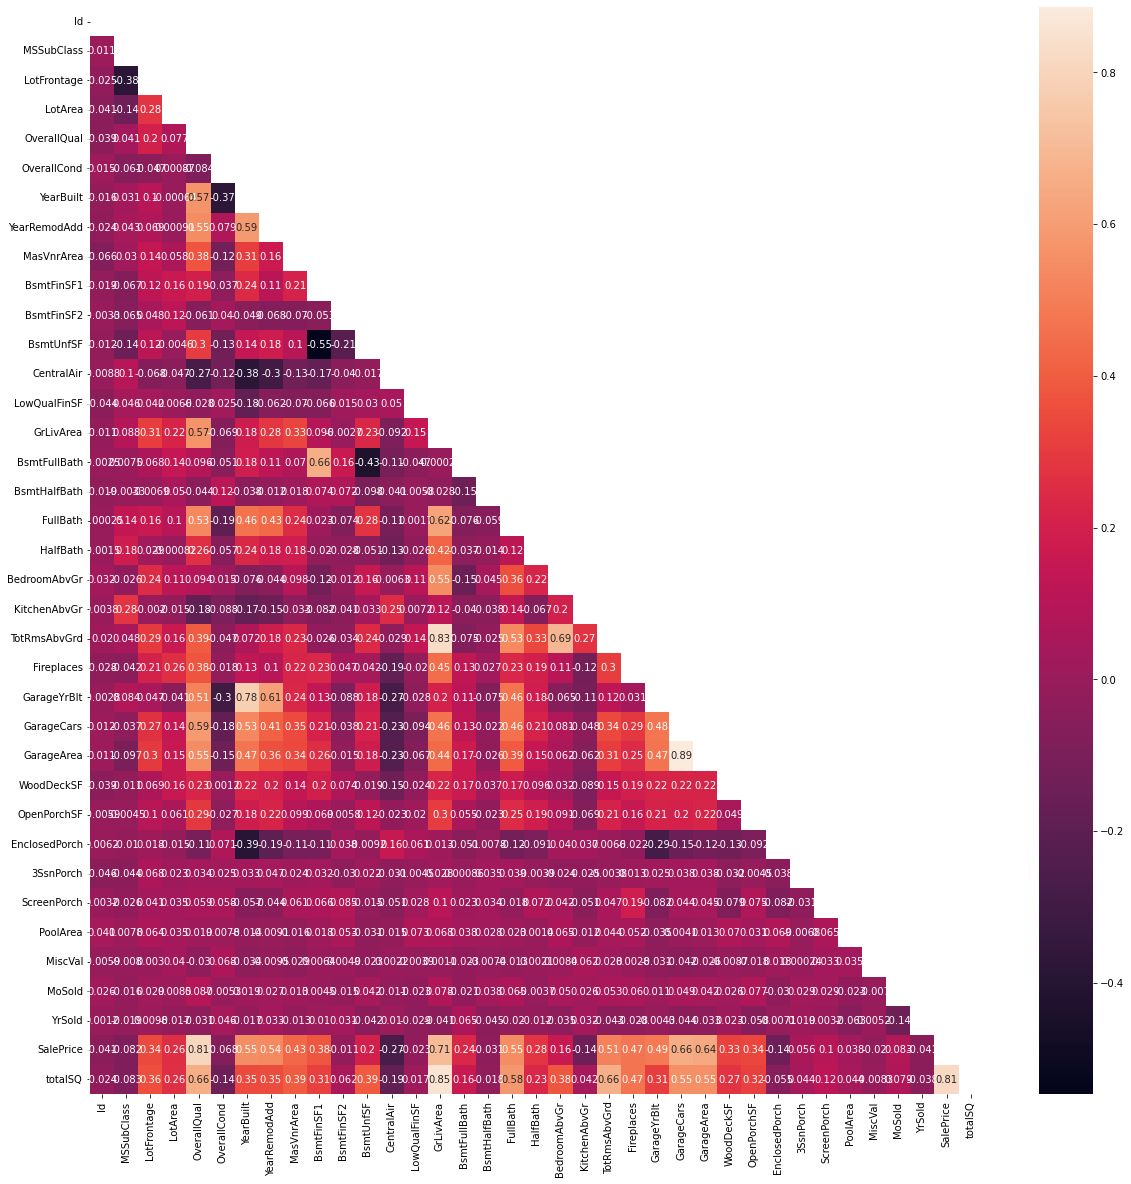

In [11]:
import seaborn as sns
corr= df.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(20,20))    
sns.heatmap(corr, annot=True, mask=matrix)

In [12]:
#Too similiar variables:
df=df.drop(['GarageYrBlt'], axis=1)

In [13]:
df['bathrooms']=df['BsmtHalfBath']+df['FullBath']+df['HalfBath']+df['BsmtHalfBath']

#Had less than .001 feature importance:
df=df.drop(['BsmtFinSF2','LowQualFinSF','BsmtHalfBath', 'FullBath', 
            '3SsnPorch', 'ScreenPorch','MiscVal', 'PoolArea', 
            'MoSold', 'EnclosedPorch', 'MasVnrArea', 'YrSold',
             'BedroomAbvGr', 'BsmtFullBath', 'HalfBath'], axis=1)

#After removing above, these had less than .004 feature importance:
df=df.drop(['MSSubClass', 'LotFrontage', 'TotRmsAbvGrd' ], axis=1)

# Split Data

In [14]:
from sklearn.model_selection import train_test_split, cross_validate

X=df.drop("SalePrice", axis='columns')
y=df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.30, random_state=42)

# xgBoost

In [15]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Max Depth Tunning
Increasing the value makes the model more complex which could overfit. Four for max depth shows the least amount of error and highest accuracy. 

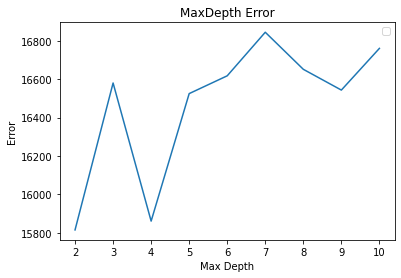

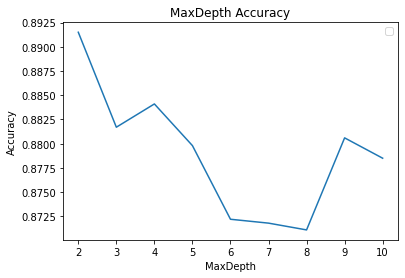

In [16]:
maxDepth=[2, 3, 4, 5, 6, 7, 8, 9, 10]
listMSE=[]
listR2=[]

for d in maxDepth:
    regressor = xgb.XGBRegressor(
        max_depth=d
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(maxDepth, listMSE)
plt.title('MaxDepth Error')
plt.ylabel('Error')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

plt.plot(maxDepth, listR2)
plt.title('MaxDepth Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('MaxDepth')
plt.legend()
plt.show()

### N_Estimators Tunning


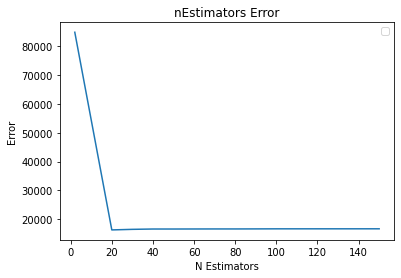

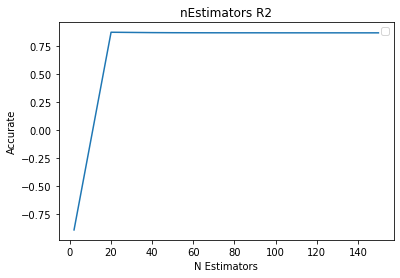

In [17]:
def xgEst():
    numbers=[2, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBRegressor(
            n_estimators=n,
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)
    plt.plot(numbers, listMSE)
    plt.title('nEstimators Error')
    plt.ylabel('Error')
    plt.xlabel('N Estimators')
    plt.legend()
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('nEstimators R2')
    plt.ylabel('Accurate')
    plt.xlabel('N Estimators')
    plt.legend()
    plt.show()
xgEst()

### Min_child_weight
Increasing value will make model more conservative. Typically, a number between 0 and 10 is used.


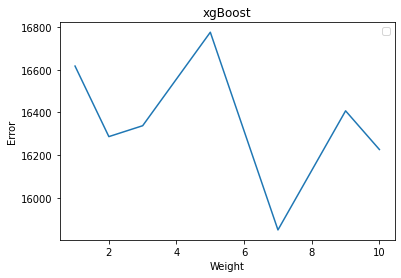

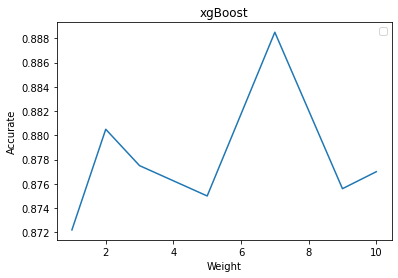

In [18]:
weight=[1, 2, 3, 5, 7, 9, 10]
listMSE=[]
listR2=[]

for w in weight:
    regressor = xgb.XGBRegressor(
        min_child_weight=w
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(weight, listMSE)
plt.title('xgBoost')
plt.ylabel('Error')
plt.xlabel('Weight')
plt.legend()
plt.show()

plt.plot(weight, listR2)
plt.title('xgBoost')
plt.ylabel('Accurate')
plt.xlabel('Weight')
plt.legend()
plt.show()

### Gamma
Increasing gamma makes model more conservative. In this case, increasing Gamma makes almost no difference. It takes gamma to be 1000 to notice a slight decrease in error. Therefore, I do not use gamma in this particular case.

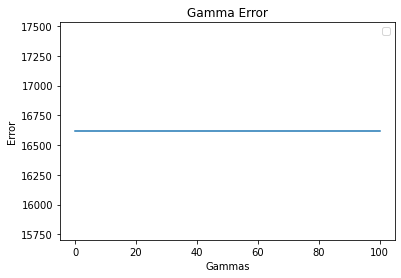

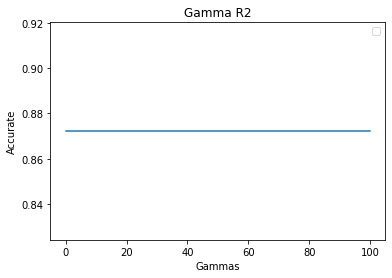

In [19]:
gammas=[0, 0.25, 0.5, 1.0, 3, 5, 100]
listMSE=[]
listR2=[]

for g in gammas:
    regressor = xgb.XGBRegressor(
        min_split_loss=g
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(gammas, listMSE)
plt.title('Gamma Error')
plt.ylabel('Error')
plt.xlabel('Gammas')
plt.legend()
plt.show()

plt.plot(gammas, listR2)
plt.title('Gamma R2')
plt.ylabel('Accurate')
plt.xlabel('Gammas')
plt.legend()
plt.show()

### Learning_rate
A higher learning rate makes the model more conservative. Range is between 0 and 1. Typically, a number between 0 and .3 is used.

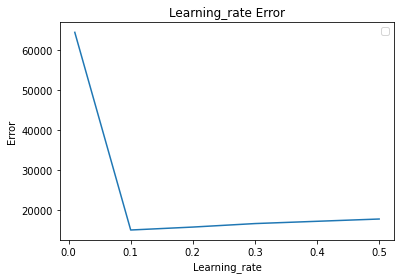

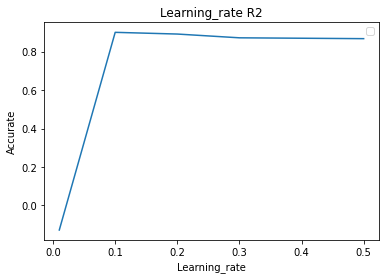

In [20]:
learning_rate = [0.01, 0.1, 0.2, 0.3, .5]
listMSE=[]
listR2=[]

for l in learning_rate:
    regressor = xgb.XGBRegressor(
        learning_rate=l
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(learning_rate, listMSE)
plt.title('Learning_rate Error')
plt.ylabel('Error')
plt.xlabel('Learning_rate')
plt.legend()
plt.show()

plt.plot(learning_rate, listR2)
plt.title('Learning_rate R2')
plt.ylabel('Accurate')
plt.xlabel('Learning_rate')
plt.legend()
plt.show()

### Reg_Lambda
Reg_lambda uses L2 regularization. 

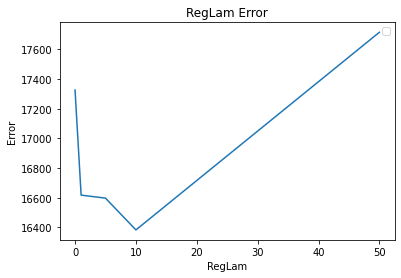

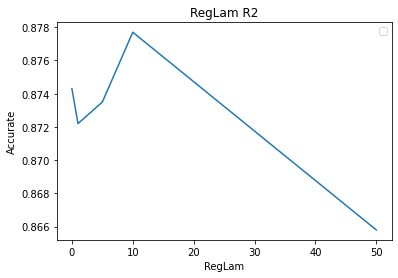

In [21]:
regLam = [0, 1.0, 5.0, 10.0, 50.0] #0 is default
listMSE=[]
listR2=[]

for r in regLam:
    regressor = xgb.XGBRegressor(
        reg_lambda=r,
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(regLam, listMSE)
plt.title('RegLam Error')
plt.ylabel('Error')
plt.xlabel('RegLam')
plt.legend()
plt.show()

plt.plot(regLam, listR2)
plt.title('RegLam R2')
plt.ylabel('Accurate')
plt.xlabel('RegLam')
plt.legend()
plt.show()

### Reg_Alpha
Reg_alpha uses L1 regularization. Increasing the value makes the model more conservative. 

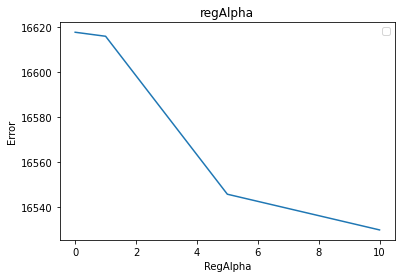

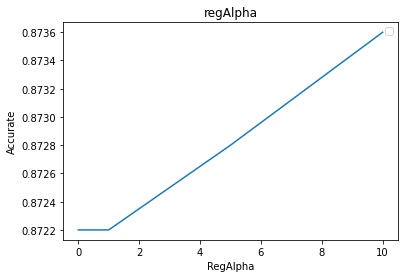

In [22]:
def regAlpha():
    numbers = [0, 1.0, 5.0, 10.0]  #0 is default
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBRegressor(
            reg_alpha=n,
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)

    plt.plot(numbers, listMSE)
    plt.title('regAlpha')
    plt.ylabel('Error')
    plt.xlabel('RegAlpha')
    plt.legend()
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('regAlpha')
    plt.ylabel('Accurate')
    plt.xlabel('RegAlpha')
    plt.legend()
    plt.show()
regAlpha()

### Colsample_bytree

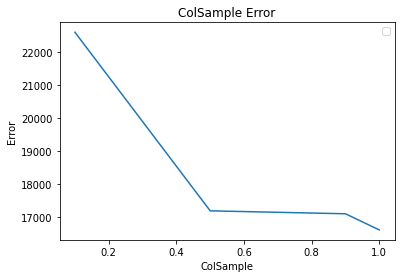

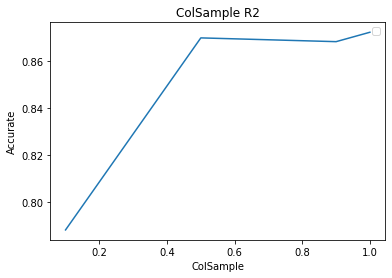

In [23]:
colSample = [0.1, 0.5, 0.9, 1]
listMSE=[]
listR2=[]

for c in colSample:
    regressor = xgb.XGBRegressor(
        colsample_bytree=c
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(colSample, listMSE)
plt.title('ColSample Error')
plt.ylabel('Error')
plt.xlabel('ColSample')
plt.legend()
plt.show()

plt.plot(colSample, listR2)
plt.title('ColSample R2')
plt.ylabel('Accurate')
plt.xlabel('ColSample')
plt.legend()
plt.show()

# Grid Search xg Boost

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import f1_score, max_error
from xgboost import cv
from scipy import stats
import time

def gridSearch():
    start=time.time()
    print("Start")

    params = {
        'learning_rate':[.1, .3, .5],
        'n_estimators':[100],
        'max_depth':[2, 3, 4],
        'min_child_weight':[5, 10],
        'reg_lambda':[0, 1, 5],
        'reg_alpha':[0, 1, 5],
        'colsample_bytree':[.9, 1],
    }

    boost_gs=xgb.XGBRegressor()
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    boost_gs=GridSearchCV(boost_gs, param_grid=params, scoring='neg_mean_squared_error', cv =5)
    boost_gs.fit(X_train, y_train)

    print(boost_gs.best_params_)
    print("Done. ", time.time()-start, " seconds")
gridSearch()

Start
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5}
Done.  492.61471033096313  seconds


# Final Predictions
Here are some of the best models found by using GridSearch:
* {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5}
* {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
* Using MSE with cv=10 {'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'reg_lambda': 0.5}
* Top 47% {'eta': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 50, 'reg_lambda': 0.01}
* Using Kfold=5 {'colsample_bytree': 0.5, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 'reg_lambda': 0.5}

In [25]:
xgbFinal = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=4,
        reg_lambda=5,
        reg_alpha=0,
        min_child_weight=10,
        learning_rate=.1,
        colsample_bytree=.90,
    )
xgbFinal.fit(X_train, y_train)
y_pred = xgbFinal.predict(X_test)

xgMSE=mean_absolute_error(y_test, y_pred)
xgR2 = r2_score(y_test, y_pred).round(4)
listMSE.append(xgMSE)
listR2.append(xgR2)

#xgbFinal.fit(X_train, y_train)
xgbFinal.fit(X_train, y_train, early_stopping_rounds=5, eval_metric="rmse", eval_set=[(X_test, y_test)], verbose=False)
y_pred = xgbFinal.predict(X_test)

xgMSE=mean_absolute_error(y_test, y_pred)
xgR2 = r2_score(y_test, y_pred).round(4)
listMSE.append(xgMSE)
listR2.append(xgR2)

xgScore = xgbFinal.score(X_test, y_test).round(4)  
xgCV = cross_validate(xgbFinal, X, y, cv = 5, scoring='r2')
xgCV=xgCV['test_score'].mean().round(4)
print(xgScore)
print(xgCV)
print(xgScore-xgCV)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


0.8932
0.8989
-0.005700000000000038


### Graph

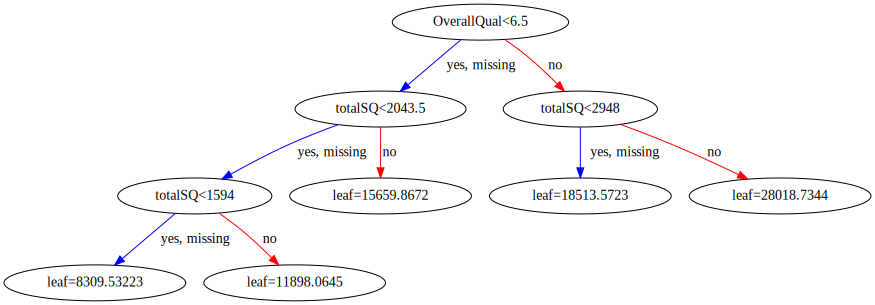

In [26]:
import graphviz
xgb.to_graphviz(xgbFinal)

# Feature Importance

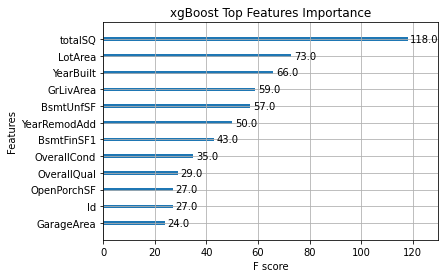

<Figure size 1440x1440 with 0 Axes>

In [27]:
xgb.plot_importance(xgbFinal, max_num_features=12, title='xgBoost Top Features Importance')
plt.figure(figsize = (20, 20))
plt.show()

In [28]:
importance=xgbFinal.feature_importances_
name=xgbFinal.feature_names_in_
print("Feature Importance:")
for num in range(len(name)):
    print(importance[num], " ", name[num])

Feature Importance:
0.0037916137   Id
0.00934264   LotArea
0.50823265   OverallQual
0.0086100865   OverallCond
0.020347413   YearBuilt
0.024686586   YearRemodAdd
0.013045347   BsmtFinSF1
0.0057915933   BsmtUnfSF
0.017630491   CentralAir
0.016446546   GrLivArea
0.07987542   KitchenAbvGr
0.019777907   Fireplaces
0.09059901   GarageCars
0.009796291   GarageArea
0.005605811   WoodDeckSF
0.0049918033   OpenPorchSF
0.15007845   totalSQ
0.011350359   bathrooms


In [29]:
def randSearch():
    clf_xgb = xgb.XGBRegressor()
    param_dist = {'n_estimators': stats.randint(50, 130),
                  'learning_rate': stats.uniform(0.01, 0.07),
                  'subsample': stats.uniform(0.3, 0.7),
                  'max_depth': [3, 4, 5, 6],
                  'colsample_bytree': stats.uniform(0.5, 0.45),
                  'min_child_weight': [1, 10]
                 }
    clf = RandomizedSearchCV(
        clf_xgb, param_distributions = param_dist, n_iter = 10, 
     scoring = 'r2', error_score = 0, verbose = 3, n_jobs = -1)

    numFolds = 5
    folds = KFold(n_splits = numFolds, shuffle = True)

    estimators = []
    results = np.zeros(len(X))
    score = 0.0
    for train_index, test_index in folds.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
        clf.fit(X_train, y_train)

        estimators.append(clf.best_estimator_)
        results[test_index] = clf.predict(X_test)
        score += r2_score(y_test, results[test_index])
    score /= numFolds

# Test Dataset
Make final predictions on unknown house price value using features from Train data

In [30]:
test='/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
testDF=pd.read_csv(test)
print(testDF.shape)

#Missing Values
testDF=testDF.drop_duplicates()
testDF=testDF.fillna(testDF.mean())

# Feature Engineer
testDF['totalSQ']=testDF['1stFlrSF']+testDF['2ndFlrSF']+testDF['TotalBsmtSF']
testDF['bathrooms']=testDF['BsmtHalfBath']+testDF['FullBath']+testDF['HalfBath']+testDF['BsmtHalfBath']
testDF['CentralAir'] = testDF['CentralAir'].replace({'Y':0, 'N':1})

#testDF['SaleCondition']=testDF['SaleCondition'].apply(lambda x:1 if x == 'Normal' else 0)
#testDF['Street']=testDF['Street'].fillna(0).apply(lambda x:0 if x =='Grvl' else 1)

testDF = testDF.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
testDF.head()

(1459, 80)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,totalSQ,bathrooms
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,120,0,0,6,2010,1778.0,1.0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,36,0,0,0,0,12500,6,2010,2658.0,2.0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,34,0,0,0,0,0,3,2010,2557.0,3.0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,36,0,0,0,0,0,6,2010,2530.0,3.0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,82,0,0,144,0,0,1,2010,2560.0,2.0


In [31]:
testIDs=testDF['Id']
cols=X_test.columns
testDF=testDF[cols]

In [32]:
#Final Prediction
finalPred=xgbFinal.predict(testDF).round(2)
tupDF=list(zip(testIDs,finalPred))

In [33]:
output=pd.DataFrame(tupDF, columns=['Id','SalePrice']).sort_values(by='Id').reset_index(drop=True)
output.head()

,Id,SalePrice
0,1461,123040.882812
1,1462,164010.812500
2,1463,186285.125000
3,1464,191905.046875
4,1465,187793.312500


#### Final Prediction

In [34]:
print(output.shape)
output.to_csv('submission.csv', index=False)
print("Output Created")

(1459, 2)
Output Created
